# Preprocessing data 

Questions:
* combine dataset or not

Beter om functies te maken van het preprocessen. I.v.m. out of memory. Dus niet de datasets samenvoegen, maar de preprocessing op beide toepassen.

* balance clickbool, bookbool - delete all 0 bookbools?

Ja, dat vond ze wel een goed idee, dat kan ook prima als we dus de sets gescheiden houden

* PCA wanneer je het weet, wat doe je er dan mee?

Dan reduceer je de features, maar omdat er weinig correlatie is en omdat er maar 2 features overblijven leek het haar niet heel nuttig. We kunnen het evt. wel vermelden in het report

* Position, Clickbool en bookbool zijn de targets toch?

Ja, dat klopt.



In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [23]:
df_train = pd.read_csv("data/training_set_VU_DM.csv")
df_test  = pd.read_csv("data/test_set_VU_DM.csv")


## Transform datetime

In [27]:
def transform_datetime(df_comb):    
    df_comb["date_time"] = pd.to_datetime(df_comb["date_time"])
    df_comb["year"] = df_comb["date_time"].dt.year
    df_comb["month"] = df_comb["date_time"].dt.month
    df_comb = df_comb.drop(columns="date_time")
    return df_comb

df_train = transform_datetime(df_train) 
df_test  = transform_datetime(df_test)

## Remove outliers / exlcuding nan-columns

In [28]:
def remove_outliers(df_comb):    
    cols_missing = df_comb.columns[df_comb.isnull().any()].tolist()

    for col in df_comb.columns:
        if col not in cols_missing:
            Q1 = df_comb[col].quantile(0.25)
            Q3 = df_comb[col].quantile(0.75)
            IQR = Q3 - Q1
            upper_values = Q3 + 1.5 * IQR
            lower_values = Q1 - 1.5 * IQR
            # tried to follow this example, but it didn't work out: https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles
            # df_train = df_train[~((df_train[col] < (Q1 - 1.5 * IQR)) |(df_train[col] > (Q3 + 1.5 * IQR))).any(axis=1)]
            to_be_removed = list(df_comb.loc[((df_comb[col] < lower_values) | (df_comb[col] > upper_values))].index)
            
    #for index in indices_to_remove:
    rows_to_be_removed = list(set(to_be_removed))
    df_comb = df_comb.drop(index=rows_to_be_removed, errors="ignore", axis=0)
    # display(df_train)
    return df_comb

df_train = remove_outliers(df_train)
df_test  = remove_outliers(df_test)      

## Outlier detection / nan-columns

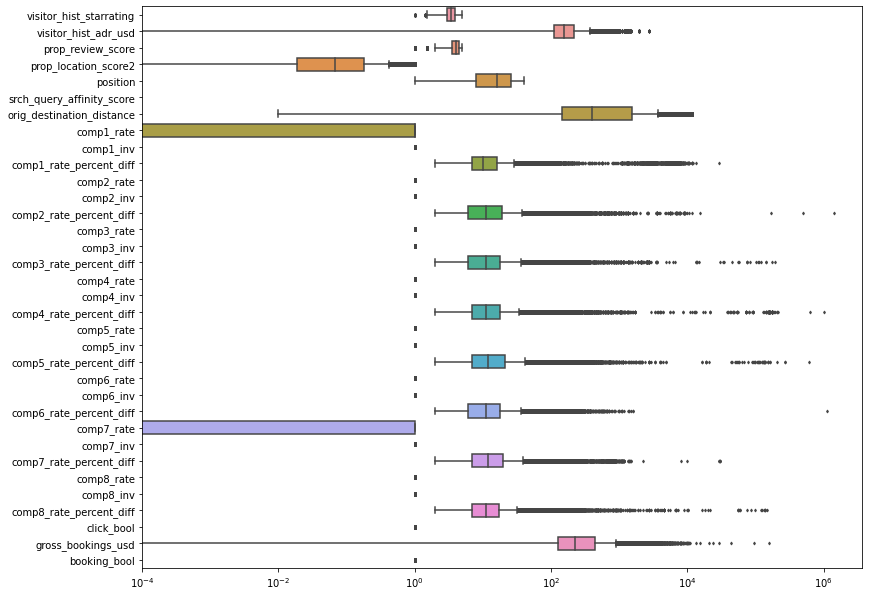

In [ ]:
def outliers():
    # cols = [
    #         'prop_location_score2',
    #         'prop_location_score1',
    #         'srch_booking_window',
    #         'price_usd',
    #         'prop_historical_price',
    #         'orig_destination_distance',
    #         ]
    cols = df_comb.columns[df_comb.isnull().any()].tolist()
    fig, axarr = plt.subplots(figsize=(2000/120, 1200/120))
   # ax = df[cols].boxplot(rot=90, return_type="axes", sym='k.', showfliers=True)
    """
    train[cols].boxplot(vert=False, sym='k.')
    plt.xscale('log')
    """
    #vals = [x.dropna() for y,x in df[cols].iteritems()]
    ax = sns.boxplot(data=df_comb[cols], orient='h', fliersize=2)
    ax.set_xscale('log')
    plt.xlim(xmin=1e-4)
    plt.subplots_adjust(left=0.3, bottom=0.1)
    # plt.savefig("outliers", dpi=400)

outliers()

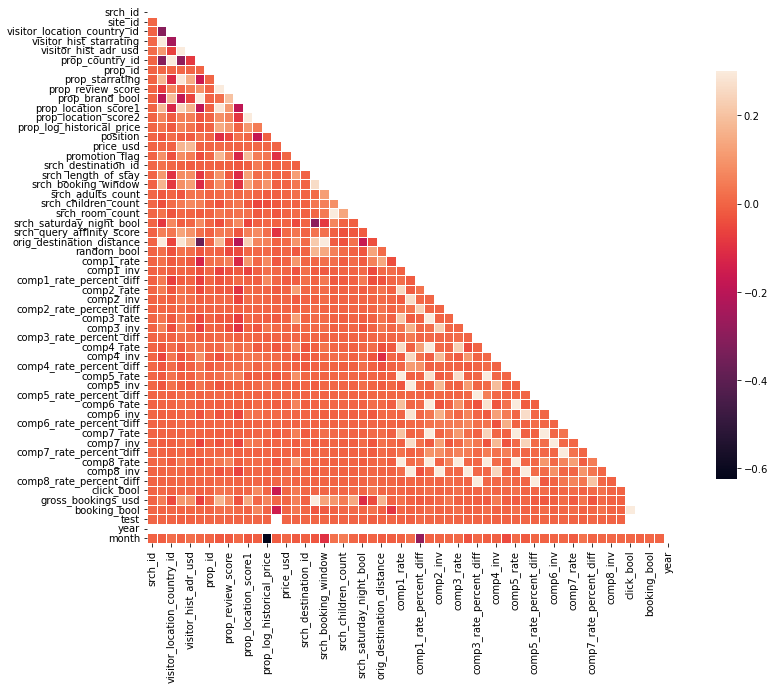

In [46]:
corr = df_comb.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.3, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

## Fill missing values

<AxesSubplot:>

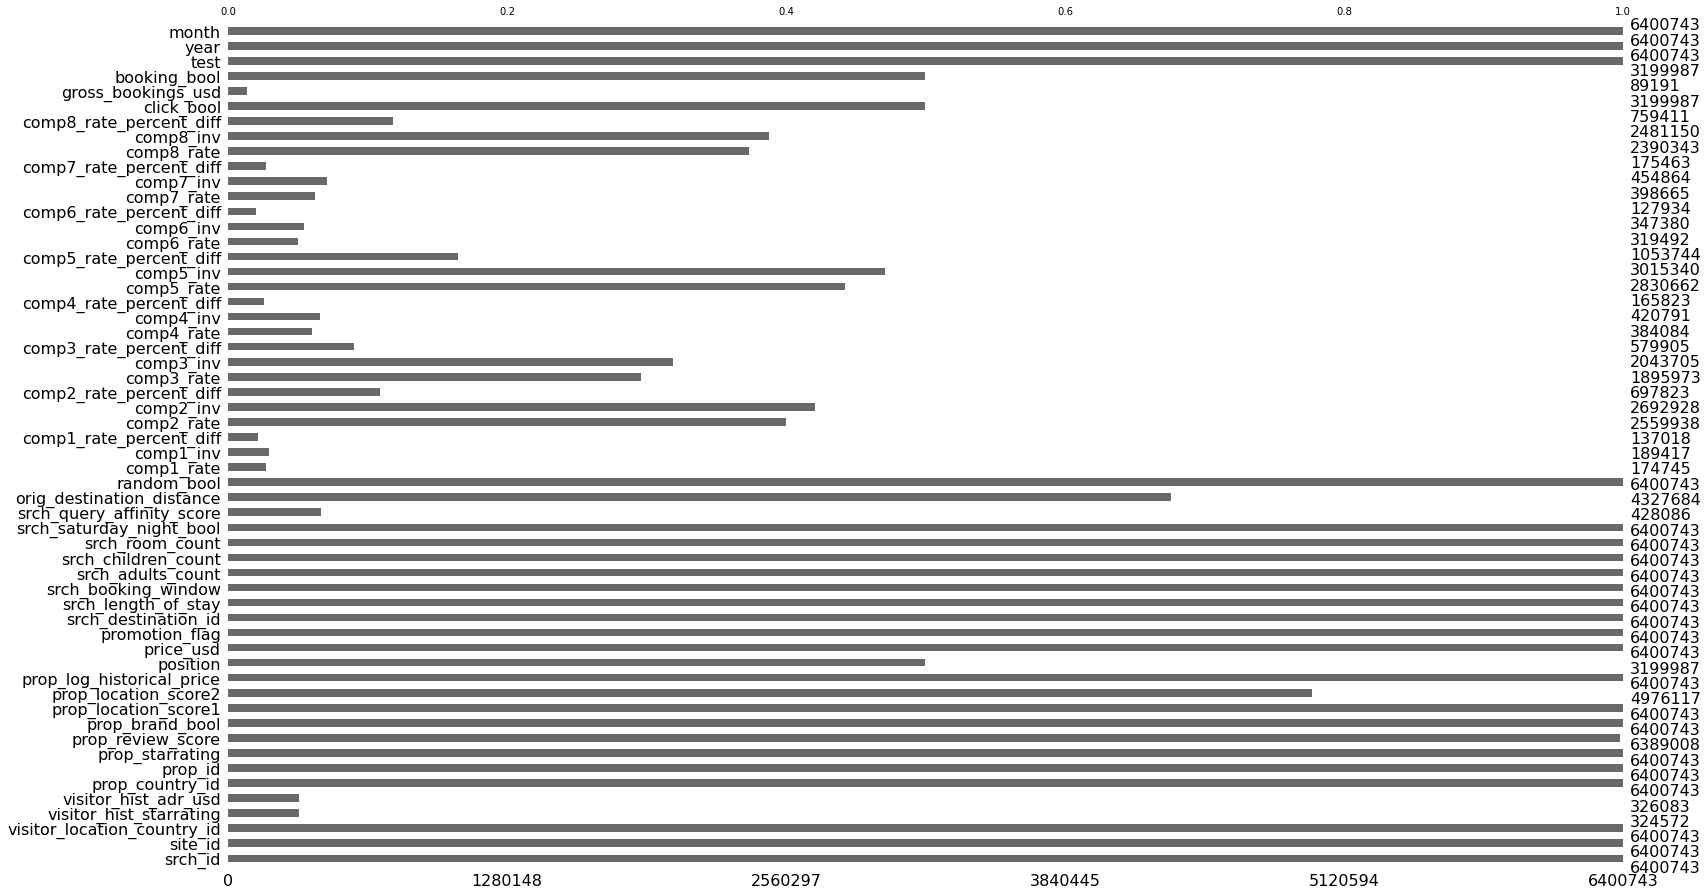

In [32]:
import missingno as msno
msno.bar(df_comb)

## Missing variables

### Hotel descriptions

These missing value estimations come from Jung Wang's solutions. People do not like booking hotels with missing information, this should be reflected in our trainingdata. In the missing value plot you can see that:

["prop_review_score", "prop_location_score2", "srch_query_affinity_score"] 

are missing values. These three variables can be catagorized as variables describing the hotel. We will set the missing variables of these values to 0. 

### orig_destination_distance

Other papers have indicated the importance of this feature https://arxiv.org/pdf/1908.07498.pdf. We therefore try and find a solution for it. In the paper they use a technique called: Distance Matrix Completion. The idea behind this is that we often know the current location of the user and the location of the hotel. However we don't have access to the actual meaning of the location id's of the data (as far as I know). In this technique we use the limited amount of data we have at orig_destination_distance to interpolate / calculate the distances of the instances we don't have. For the cases which we can't make an educated guess about the distance we take the average.

## Other variables

We are now left with three catagories of missing values: 

* gross_booking_usd: What did the transaction cost? ( 0 ?) -- If the booking bool is 0, we should set this var to 0 otherwise we should find another data. 
* Competitor values: Are the competitors cheaper, similar or more expensive in price (rate), does the competitor have the hotel available or not (inv), the percentual difference (diff)
* Visitor history: What rating has the user bought before (starrating), what have they paid for it? (adr_usd) We are lacking almost all data for these features.

Owen Zhang just sets all the missing values to -1... This makes sense for at least comp rate and comp inv, because it is the worst case scenario (Jung Wang sets them to 0, this could be possible as well). 
Team Bingshu (3rd prize) just uses the first quartile to represent the missing data.

* Position: We need to decide if we want to keep this variable, as it may cause overfitting..

In [29]:

# Calculate distance between visitor and hotel
# INTERESANT: visitor_location_country_id != prop_country and orig_destination_distance != NaN

# Reset indices
#df_unique_ids.reset_index(drop = True, inplace = True)
#df_location.reset_index(drop = True, inplace = True)
def fill_missing_values(df_comb):
        # ["prop_review_score", "prop_location_score2", "srch_query_affinity_score"]
        df_comb["prop_review_score"] = df_comb["prop_review_score"].fillna(value=0)
        df_comb["prop_location_score2"] = df_comb["prop_location_score2"].fillna(value=0)
        df_comb["srch_query_affinity_score"] = df_comb["srch_query_affinity_score"].fillna(value=0)


        df_location = df_comb[["srch_id", "visitor_location_country_id" ,"orig_destination_distance","prop_country_id"]] # These are the features we're interested in ATM

        df_location["country_id"] = np.power(df_location["visitor_location_country_id"],2) + np.power(df_location["prop_country_id"],3) # Create a unique ID based on the home country and the hotel country combination
        df_unique_ids = pd.DataFrame()
        df_unique_ids = df_location.groupby(by="country_id", as_index=False)["orig_destination_distance"].mean() # Get the mean distance between those countries # Ex: US <--> France
        df_comb["country_id"] = np.power(df_location["visitor_location_country_id"],2) + np.power(df_location["prop_country_id"],3) # Now create this same ID for the train DataFrame
        df_comb = df_comb.set_index("country_id") # We need to set the indices because otherwise we can't fill NA based on certain values
        df_unique_ids = df_unique_ids.set_index("country_id")
        df_comb.fillna(df_unique_ids["orig_destination_distance"]) # Fill the missing data with the data we allready know

        # We've filled in about 4.000 missing values in orig_destination_distance, it's not much, but it's something. 
        df_location = df_comb[["srch_id", "visitor_location_country_id" ,"orig_destination_distance","prop_country_id"]].drop_duplicates()
        # In this step we're filling in the missing "orig_destination_distance" values in with the mean from the current values
        df_comb['orig_destination_distance'].fillna((df_comb['orig_destination_distance'].mean()), inplace=True)

        # finally fill in all the other variables with -1
        df_comb = df_comb.fillna(value=-1)
        
        return df_comb

df_train = fill_missing_values(df_train)
df_test  = fill_missing_values(df_test)

C:\Users\sheep\AppData\Local\Temp/ipykernel_2956/102046862.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_location["country_id"] = np.power(df_location["visitor_location_country_id"],2) + np.power(df_location["prop_country_id"],3) # Create a unique ID based on the home country and the hotel country combination


## Balance dataset between clicked and not-clicked items

In [93]:
#balancing dataset
click_indices = df_comb[df_comb.click_bool == 1].index
random_indices = np.random.choice(click_indices, len(df_comb.loc[df_comb.click_bool == 1]), replace=False)
click_sample = df_comb.loc[random_indices]

not_click = df_comb[df_comb.click_bool == 0].index
random_indices = np.random.choice(not_click, sum(df_comb['click_bool']), replace=False)
not_click_sample = df_comb.loc[random_indices]

df_comb = pd.concat([not_click_sample, click_sample], axis=0)

print("Percentage of not click impressions: ", len(df_comb[df_comb.click_bool == 0])/len(df_comb))
print("Percentage of click impression: ", len(df_comb[df_comb.click_bool == 1])/len(df_comb))
print("Total number of records in resampled data: ", len(df_comb))

KeyboardInterrupt: 

## Balance dataset between booked and not-booked items

In [ ]:
#balancing dataset
book_indices = df_comb[df_comb.booking_bool == 1].index
random_indices = np.random.choice(book_indices, len(df_comb.loc[df_comb.booking_bool == 1]), replace=False)
book_sample = df_comb.loc[random_indices]

not_booked = df_comb[df_comb.booking_bool == 0].index
random_indices = np.random.choice(not_booked, sum(df_comb['booking_bool']), replace=False)
not_booked_sample = df_comb.loc[random_indices]

df_comb = pd.concat([not_booked_sample, book_sample], axis=0)

print("Percentage of not booked impressions: ", len(df_comb[df_comb.booking_bool == 0])/len(df_comb))
print("Percentage of booked impression: ", len(df_comb[df_comb.booking_bool == 1])/len(df_comb))
print("Total number of records in resampled data: ", len(df_comb))

Percentage of not booked impressions:  0.5
Percentage of booked impression:  0.5
Total number of records in resampled data:  222096


## Feature Engineering

Here are some feature engineering ideas found in the presentations of the three winners or at other sources online:

* sdahsadf

## Standardization or Normalization?
Standardization or normalization can be greatly benficial for ML. Which of the two to choose? I'm reading this blogpost to learn more: https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf
Furthermore, if we want to apply Principal Component Analysis to either optimize our data or reduce our dimensionality, our data needs to be (standardized / optimized). The question becomes, which method to apply. The blogpost indicates that every dataset can benifit from different standardisation techniques and then not every technique goes well with every type of model. One option could be to run a model selection combined with various standardization techniques on a subset of the trainingdata, to then choose a best model to train our data on. Another blogpost: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

To this end we've decided we'll make a model selection pipeline in combination with standardization / normalization selection. We'll use a subset of the trainingdata for this  

In [30]:
from sklearn import preprocessing

def normalize(df_comb):
    # The features which should not be standardized:
    neg_features = ["booking_bool", "click_bool", "srch_id", "year", "month", "site_id", "visitor_location_country_id", "prop_country_id", "prop_id", "prop_brand_bool", "promotion_flag", "srch_destination_id", "srch_saturday_night_bool", "random_bool"]
    features_to_normalize = df_comb[df_comb.columns.difference(neg_features)]
    # Apply the normalizer / standardizer on the relevant data. Optionally make a function to try out different normalizers / standardizers
    normalized_features = preprocessing.StandardScaler().fit_transform(features_to_normalize)
    # Combine the df with the normalized features with the df without normalization
    df_comb_normalized = df_comb
    df_comb_normalized[features_to_normalize.columns] = normalized_features
    return df_comb_normalized

df_train = normalize(df_train)
df_test  = normalize(df_test)

In [33]:
print(df_train.shape)
print(df_test.shape)


(3982391, 55)
(3987172, 51)
